In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases classic linear+tanh feedforward nets and full FGN nets

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
num_classes = 3
total_num_samples = 1024*num_classes

# random blobs
samples, labels = skdatasets.make_blobs(n_features=2, n_samples=total_num_samples, centers=num_classes, shuffle=True)
# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


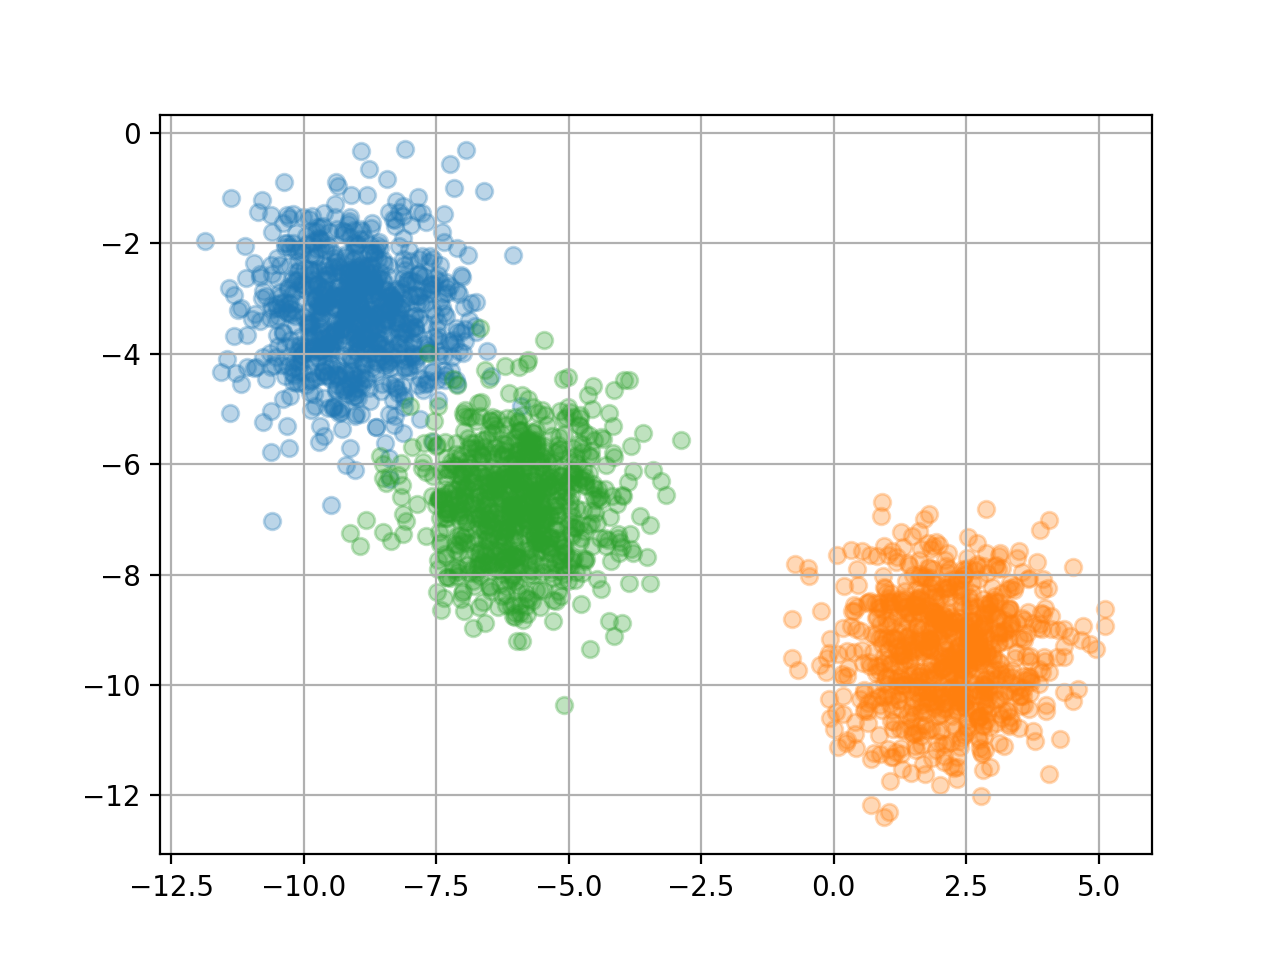

In [8]:
# 2D Check 
for label in range(num_classes):
    samples_x = [x for x,l in zip(train_samples[:,0], train_labels) if l==label]
    samples_y = [y for y,l in zip(train_samples[:,1], train_labels) if l==label]
    plt.scatter(samples_x, samples_y, alpha=0.3)


plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=192, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [10]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [11]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

0.0001628001628


In [12]:
# Initialize the classic network
hidden_l_nums = [20,20]
drop_p = 0.

In [13]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=num_classes, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [14]:
# define model params to optimize
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [15]:
epochs = 5

In [16]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 5
Epoch 0 Train set - Average loss: 0.2601, Accuracy: 2165/2457 (88%)
Test set - Average loss: 1.3959, Accuracy: 424/615 (69%)
Epoch 1 Train set - Average loss: 0.0503, Accuracy: 2416/2457 (98%)
Test set - Average loss: 0.2434, Accuracy: 557/615 (91%)
Epoch 2 Train set - Average loss: 0.0265, Accuracy: 2438/2457 (99%)
Test set - Average loss: 0.0586, Accuracy: 602/615 (98%)
Epoch 3 Train set - Average loss: 0.0281, Accuracy: 2436/2457 (99%)
Test set - Average loss: 0.0384, Accuracy: 607/615 (99%)
Epoch 4 Train set - Average loss: 0.0237, Accuracy: 2439/2457 (99%)
Test set - Average loss: 0.0329, Accuracy: 606/615 (99%)


In [17]:
# test the statibility of the model (these numbers should be same as final lines above)
classic_test_res = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0243, Accuracy: 2437/2457 (99%)
Test set - Average loss: 0.0329, Accuracy: 606/615 (99%)


In [18]:
# scale of the heat maps
grid_max = 5.0*np.max(np.abs(samples))
print("grid range", grid_max)
X1 = np.arange(-grid_max, grid_max, grid_max/100.0)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

grid range 62.56954028226865
shape of heatmap (40000, 2)
<class 'torch.Tensor'>


In [19]:
# compute predictions for heatmap
classic_model.eval()
classic_heatmap_preds = classic_model(heatmap_inputs.to(device))
classic_heatmap_preds = classic_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
classic_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in classic_heatmap_preds])

<IPython.core.display.Javascript object>


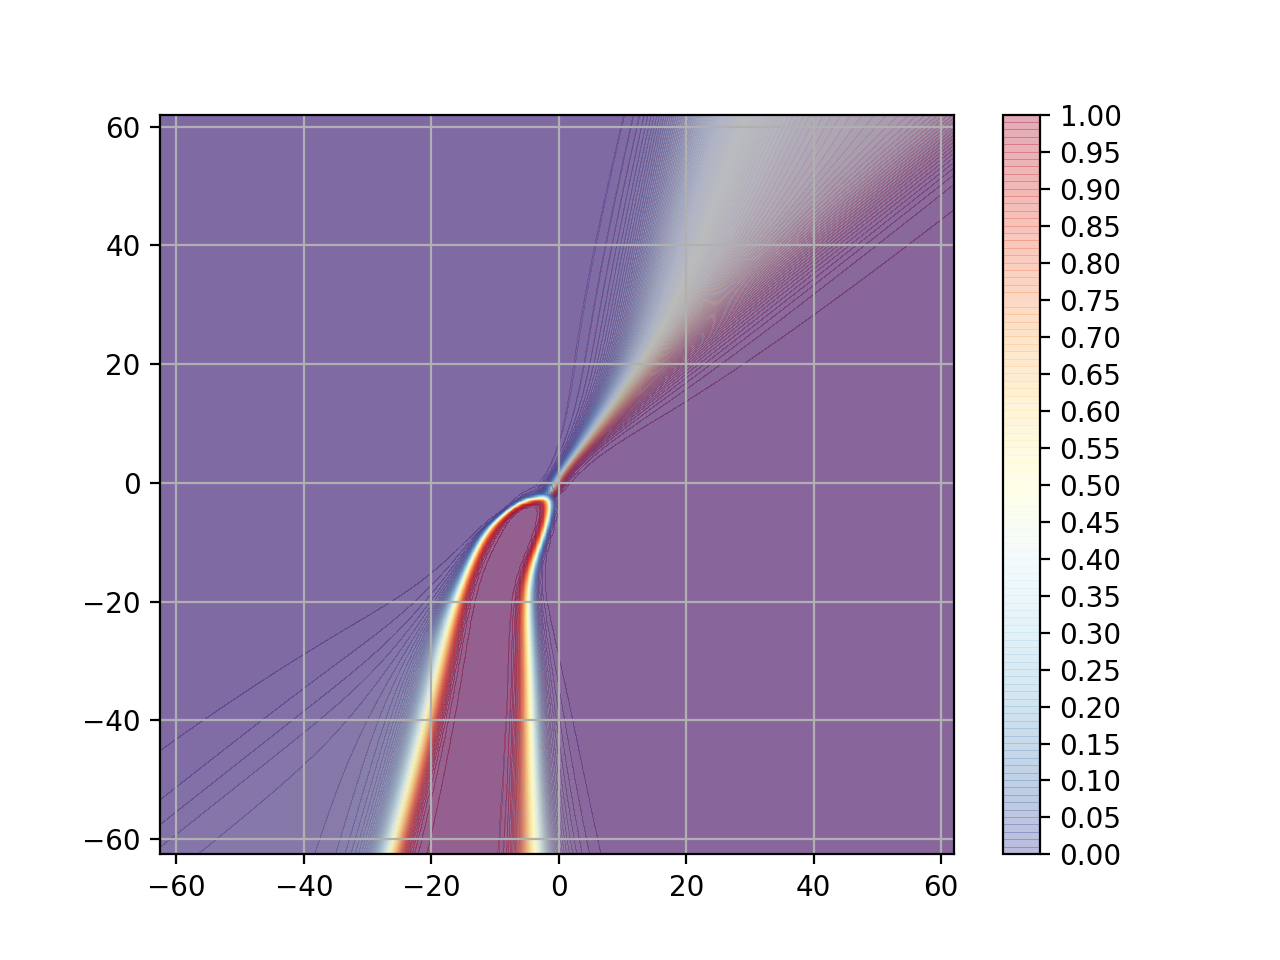

In [20]:
# plot the stacked heatmaps
levels = np.arange(-0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r, alpha=1.0/num_classes)
plt.colorbar(ticks=ticks)

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


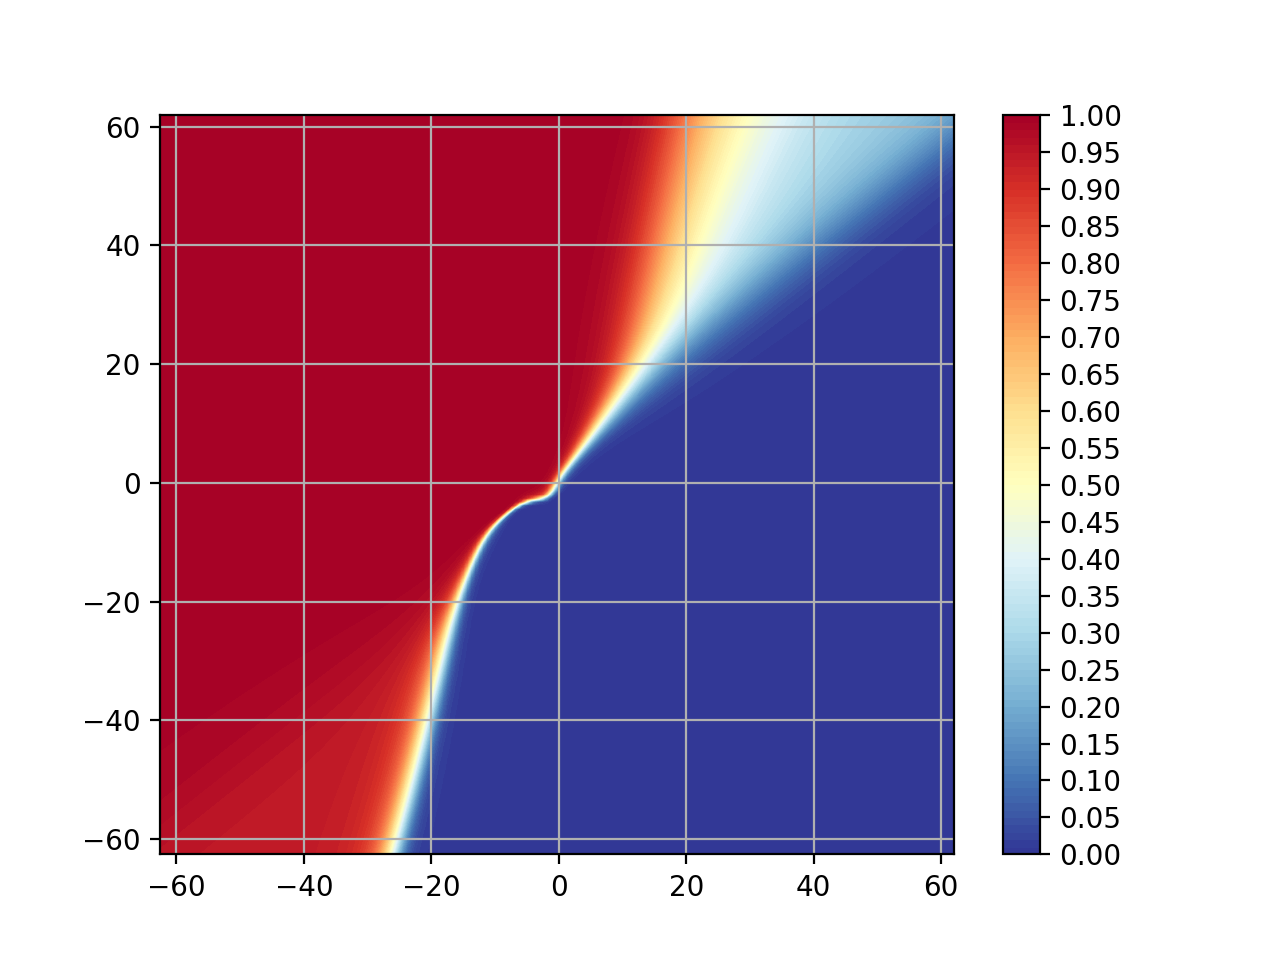

<IPython.core.display.Javascript object>


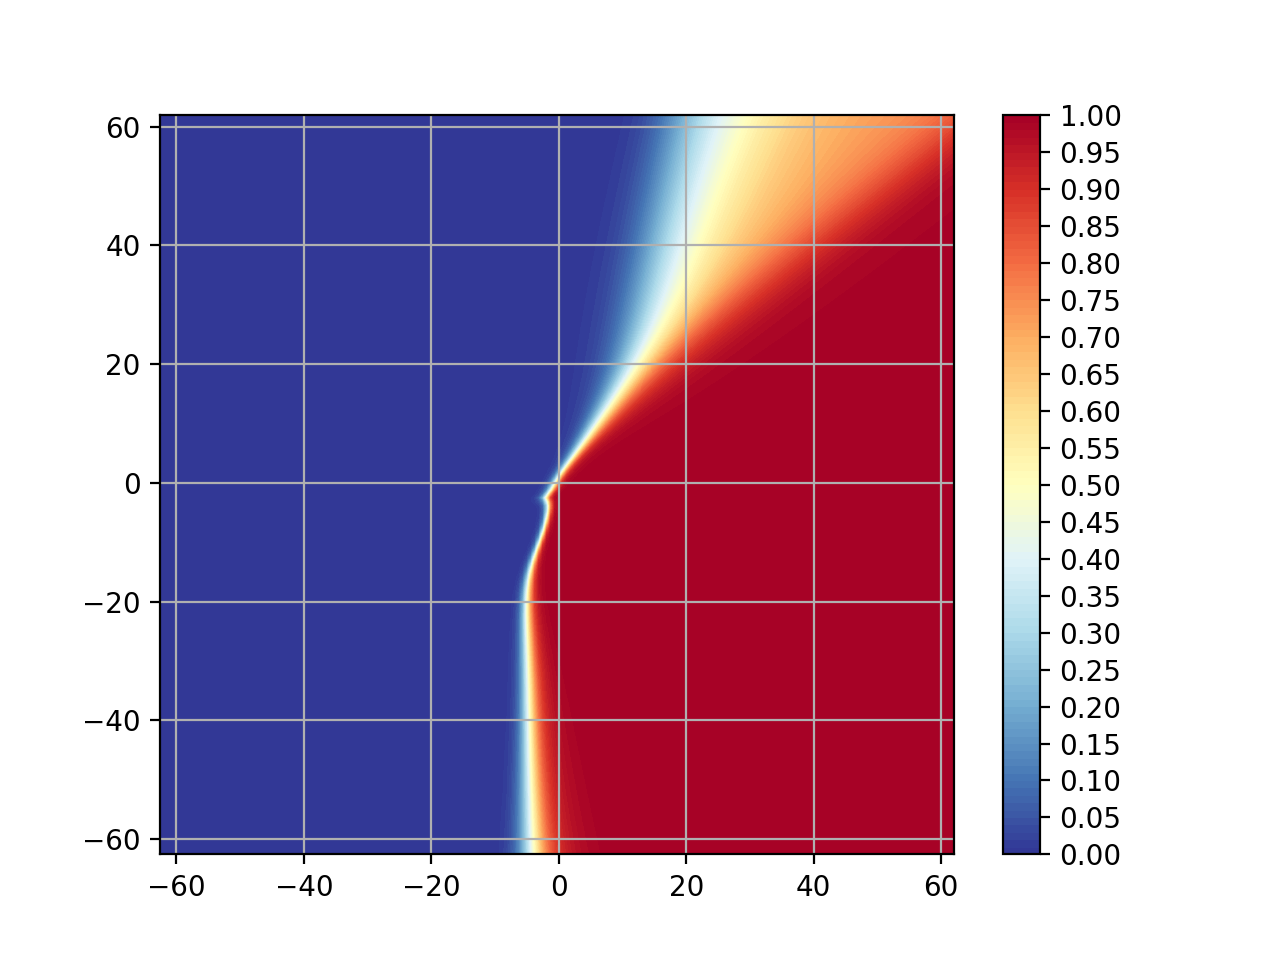

<IPython.core.display.Javascript object>


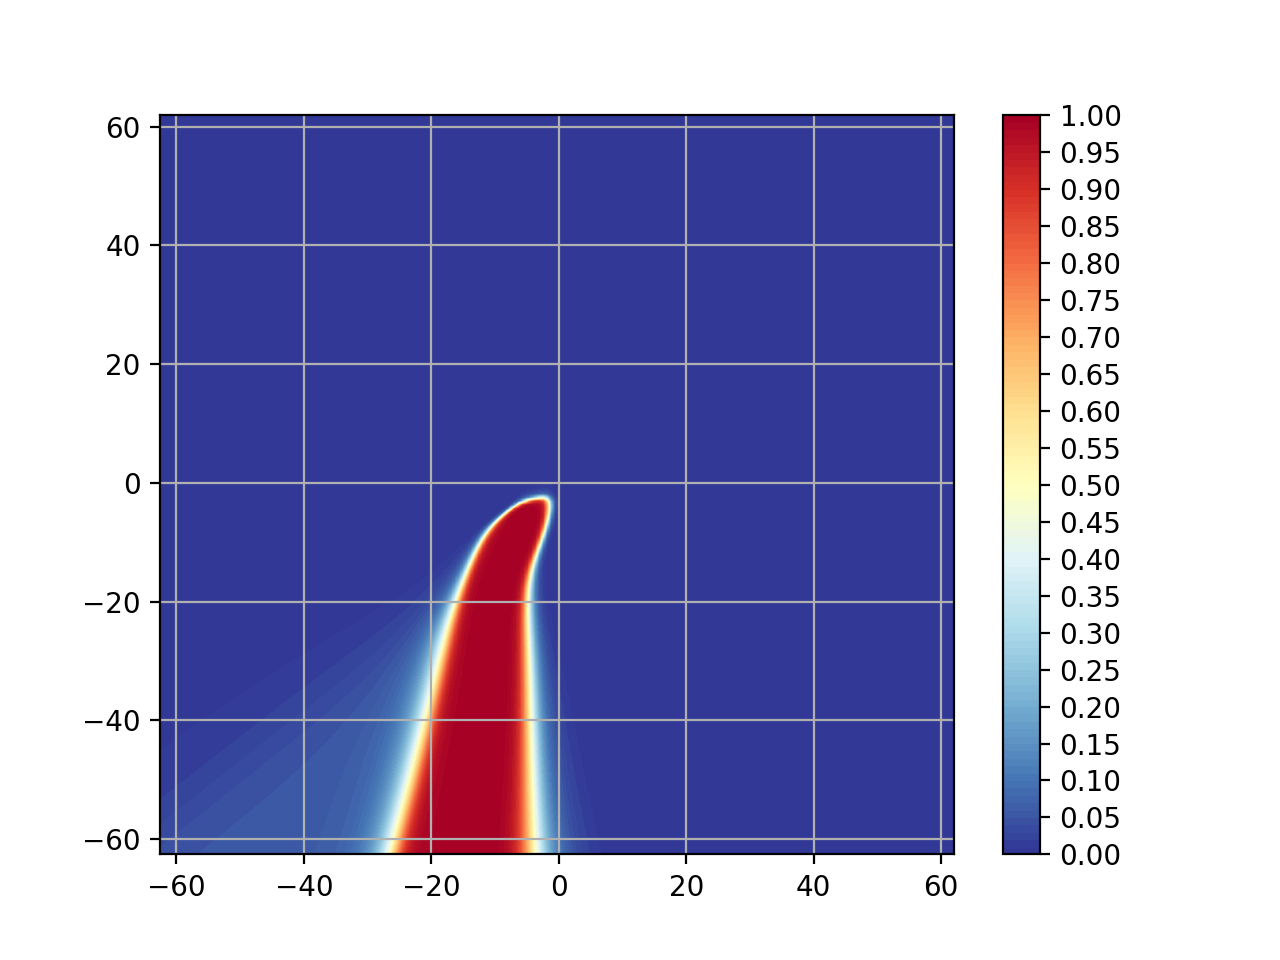

In [21]:
# plot the heatmaps individually 
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
    plt.colorbar(ticks=ticks)
    plt.grid(True)
    plt.show()

# plt.colorbar(ticks=ticks)
# plt.grid(True)
# plt.show()

In [22]:
### PART 2: fully FGN network

In [23]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = num_classes*100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 0.0001628001628
lambda for sigs^2 loss 0.04884004884


In [24]:
# Initialize the fgn network
print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
noisy_centers = True
print("noisy centers:", noisy_centers)
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=num_classes, hidden_l_nums=hidden_l_nums,
                                     drop_p=drop_p, noisy_centers=noisy_centers).to(device)

hidden layers: [20, 20]
drop prob: 0.0
noisy centers: True


In [25]:
# define model params to optimize
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [26]:
# train the network for N epochs
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.9163, Accuracy: 2242/2457 (91%)
Test set - Average loss: 3.0306, Accuracy: 410/615 (67%)
Epoch 1 Train set - Average loss: 0.4412, Accuracy: 2423/2457 (99%)
Test set - Average loss: 0.4967, Accuracy: 579/615 (94%)
Epoch 2 Train set - Average loss: 0.3622, Accuracy: 2433/2457 (99%)
Test set - Average loss: 0.3234, Accuracy: 610/615 (99%)
Epoch 3 Train set - Average loss: 0.3212, Accuracy: 2424/2457 (99%)
Test set - Average loss: 0.2809, Accuracy: 609/615 (99%)
Epoch 4 Train set - Average loss: 0.2786, Accuracy: 2430/2457 (99%)
Test set - Average loss: 0.2668, Accuracy: 607/615 (99%)


In [27]:
# test the statibility of the model (these numbers should be same as final lines above)
fgn_test_res = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2562, Accuracy: 2432/2457 (99%)
Test set - Average loss: 0.2669, Accuracy: 607/615 (99%)


In [28]:
# compute predictions for heatmap
fgn_model.eval()
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds = fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


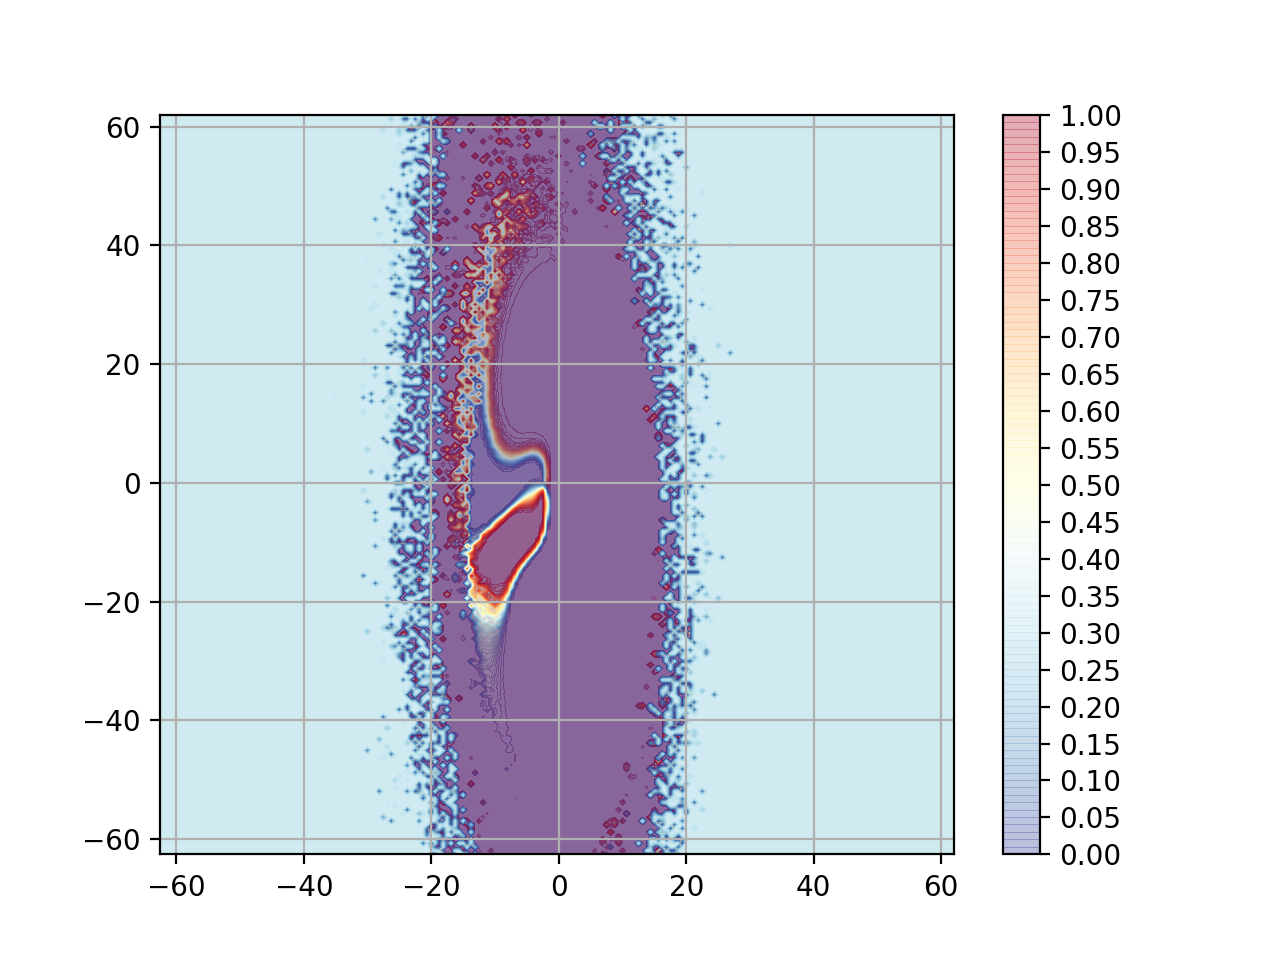

In [29]:
# plot the stacked heatmaps
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r, alpha=1.0/num_classes)

plt.colorbar(ticks=ticks)
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


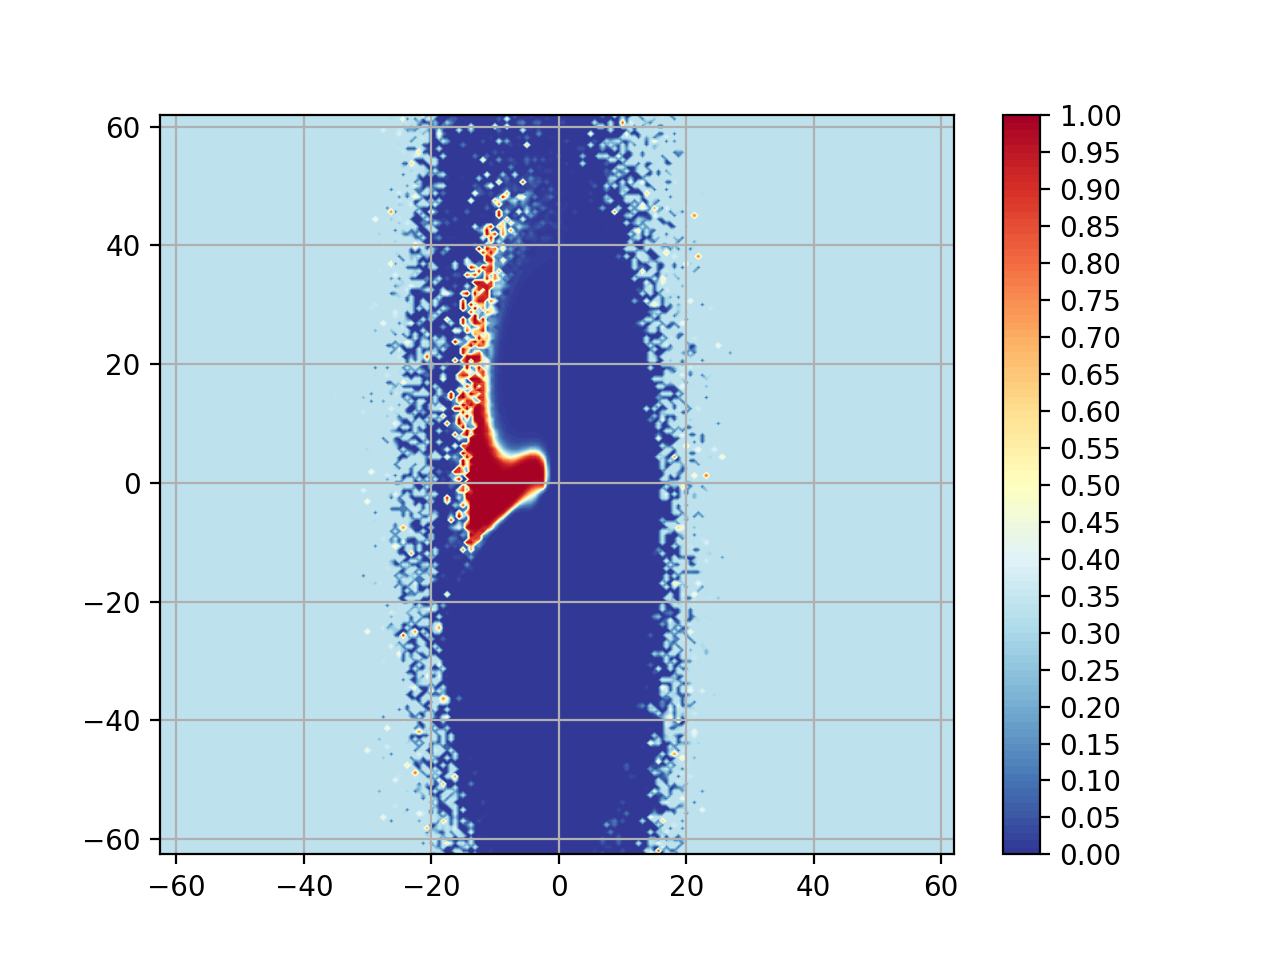

<IPython.core.display.Javascript object>


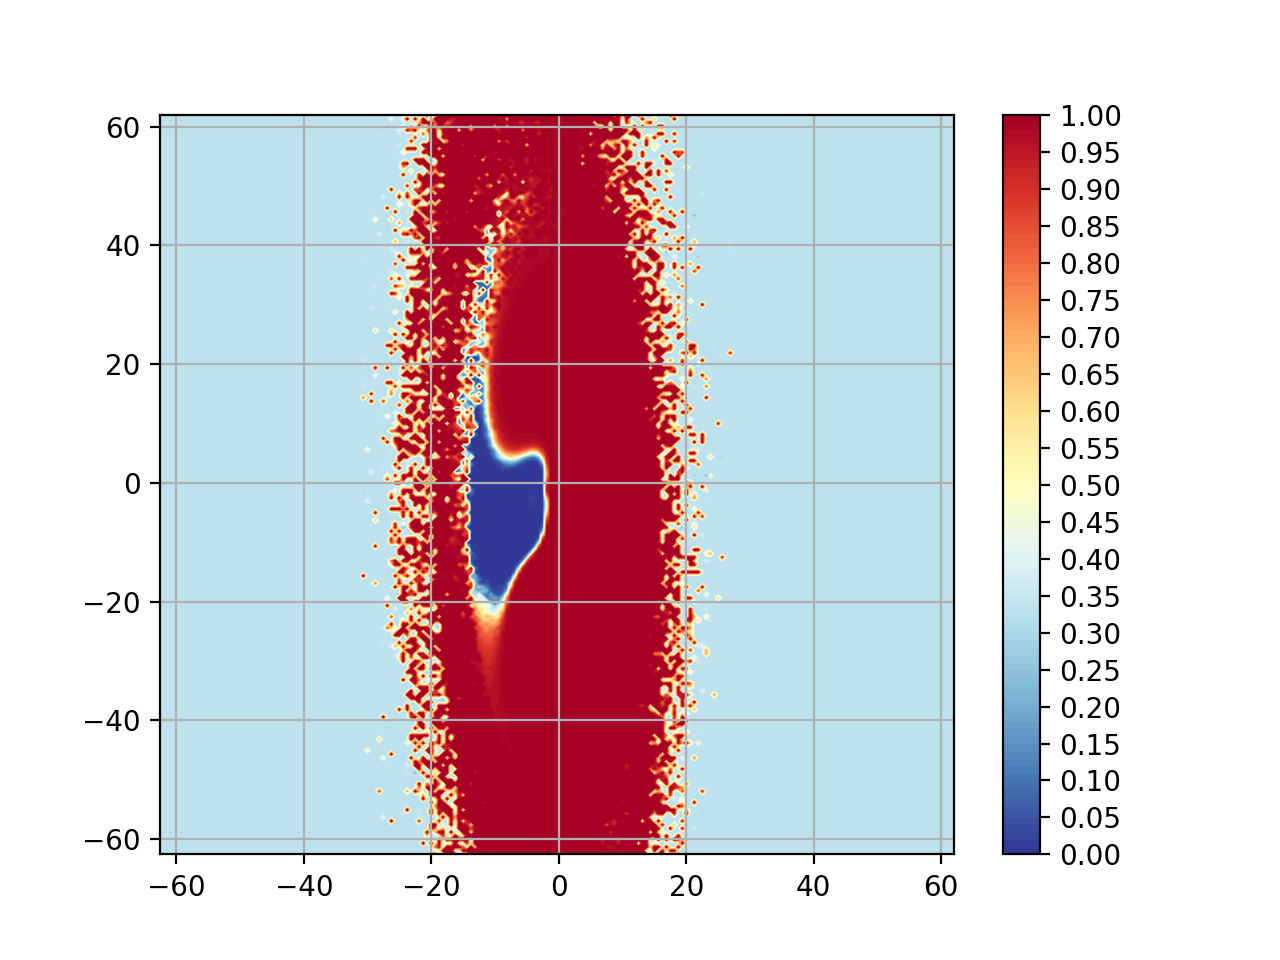

<IPython.core.display.Javascript object>


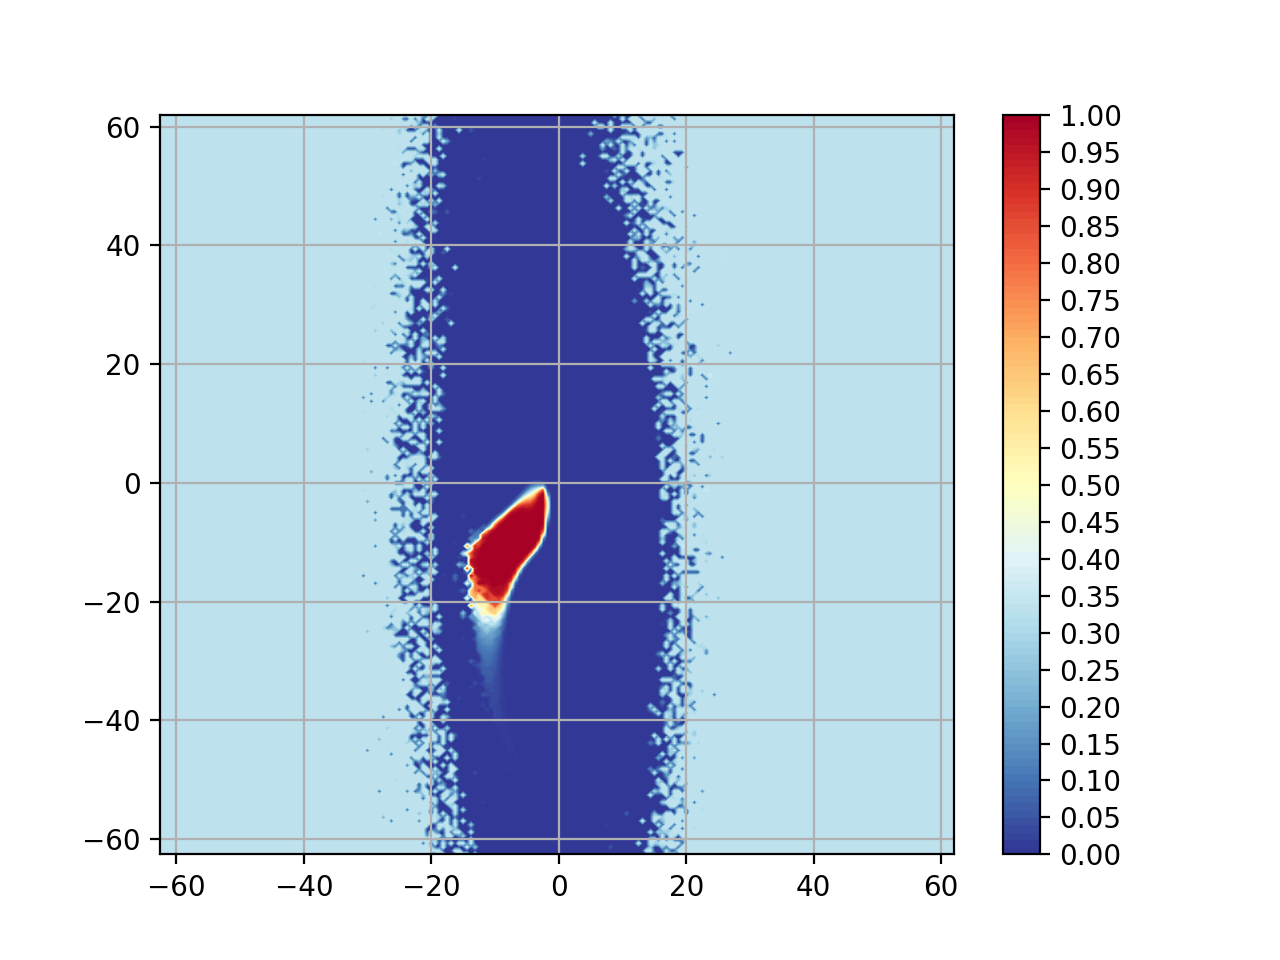

In [30]:
# plot the heatmaps individually
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
    plt.colorbar(ticks=ticks)
    plt.grid(True)
    plt.show()

<IPython.core.display.Javascript object>


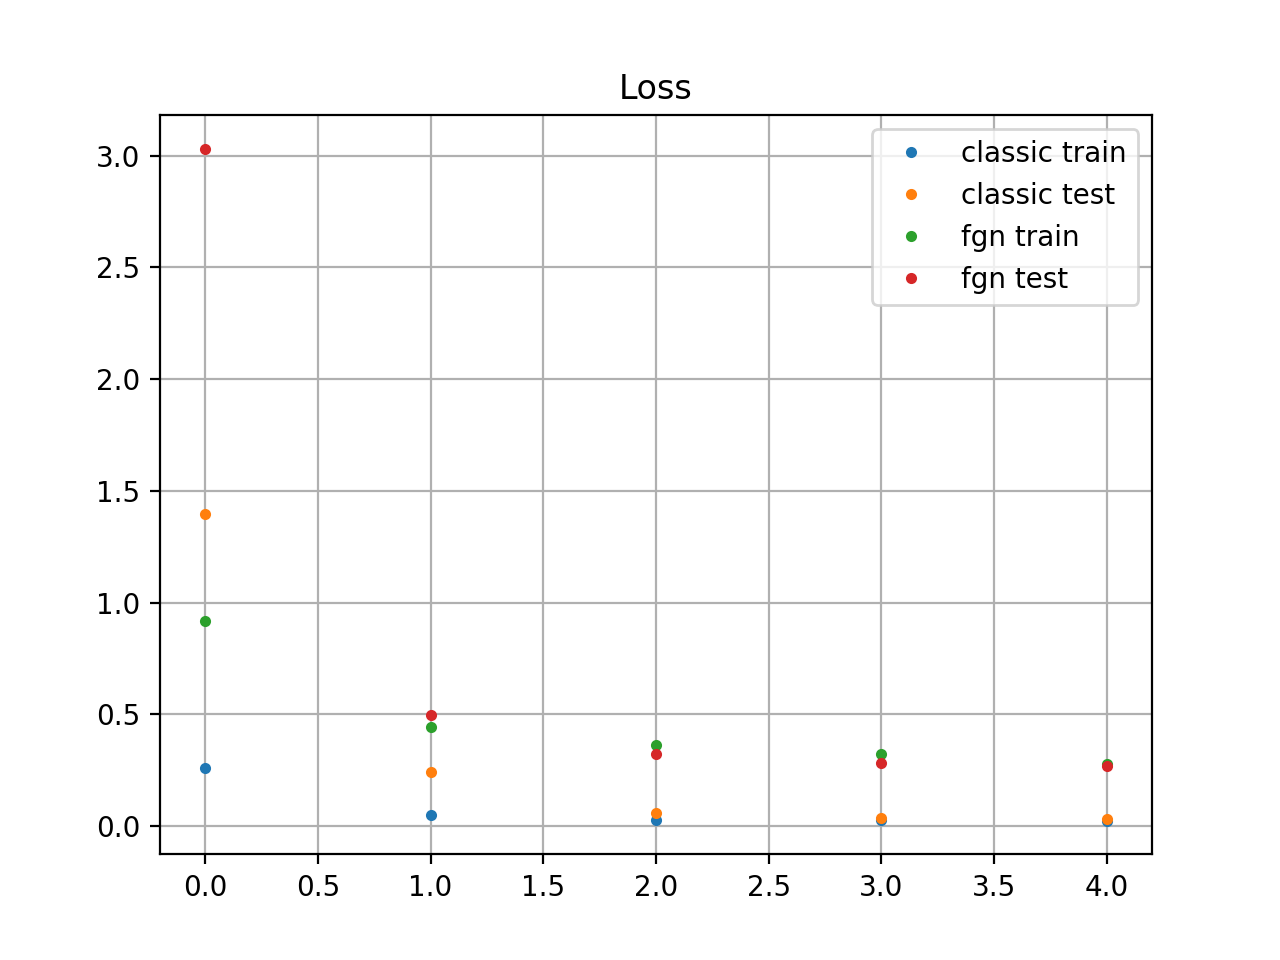

<IPython.core.display.Javascript object>


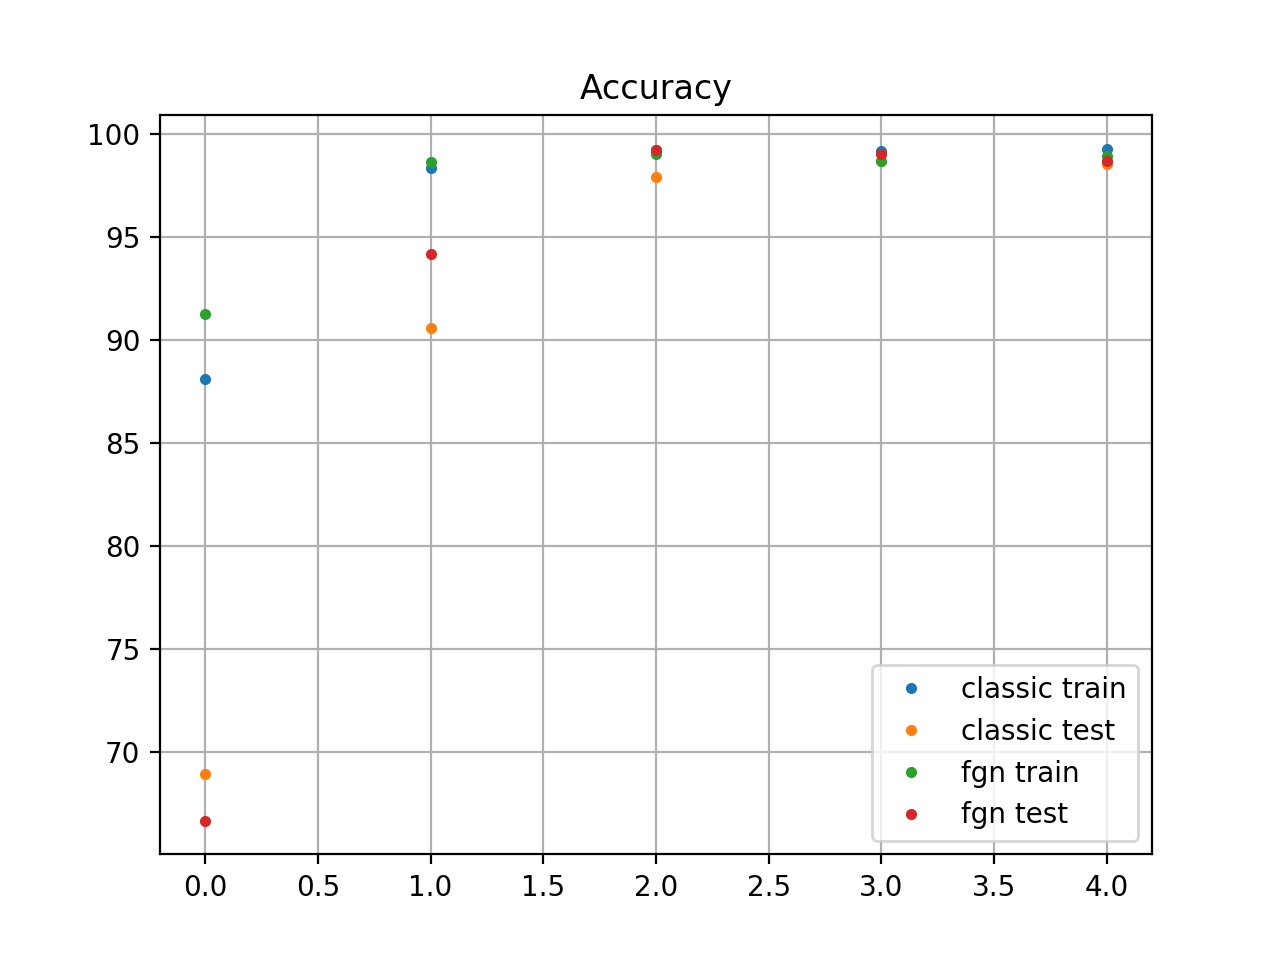

In [31]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [32]:
### plot some FGN param movement during training

fl.centers
plotting neurons: [0 2]


<IPython.core.display.Javascript object>


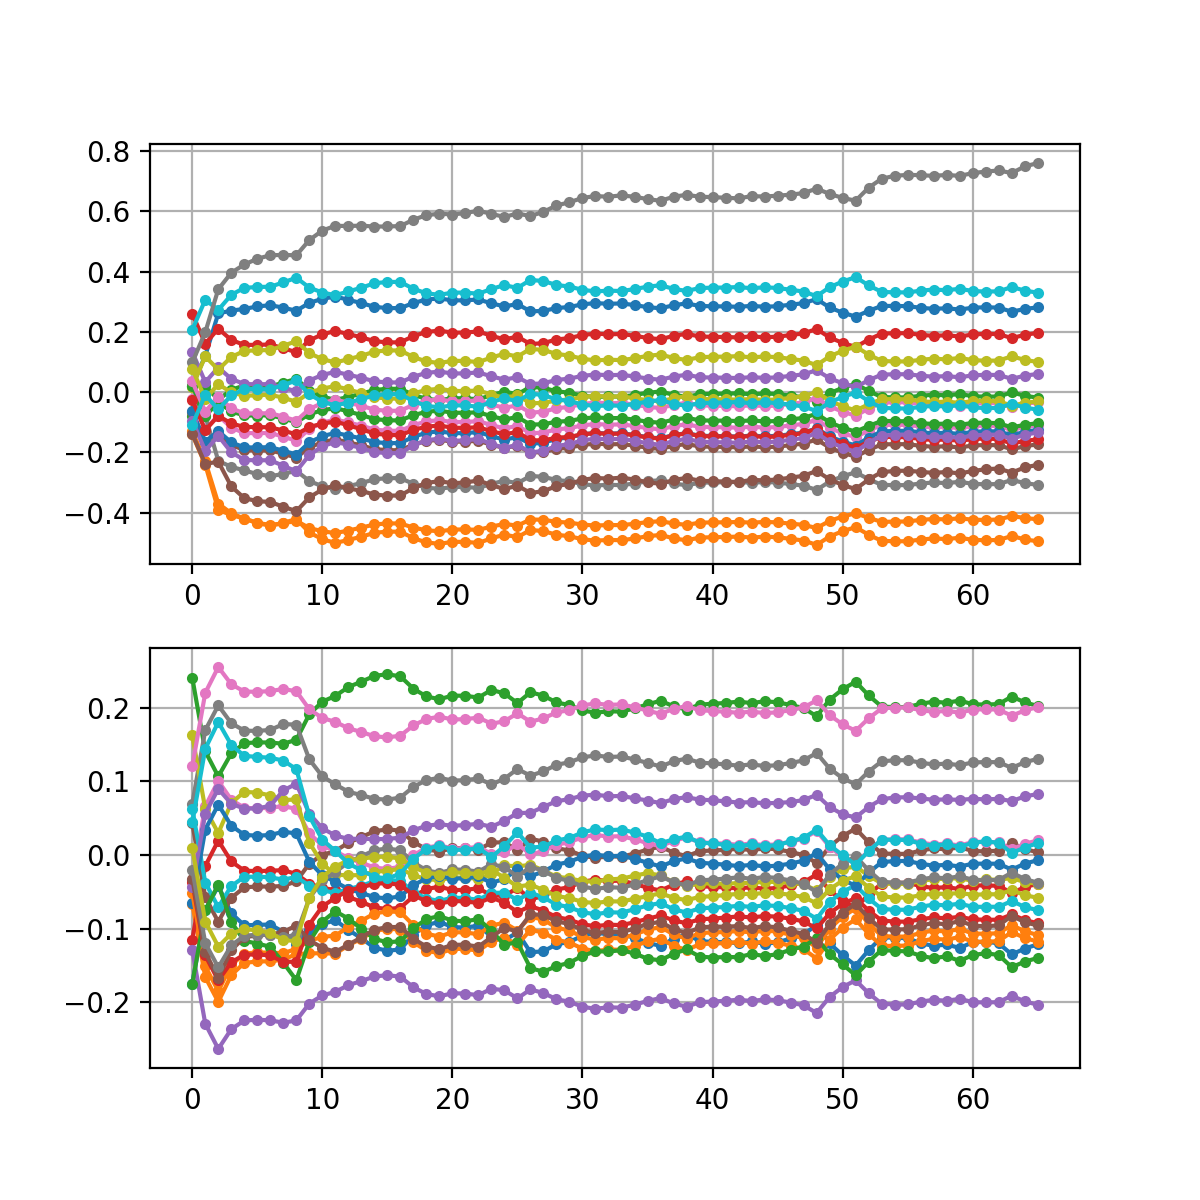

hidden_layers.2.centers
plotting neurons: [19  2]


<IPython.core.display.Javascript object>


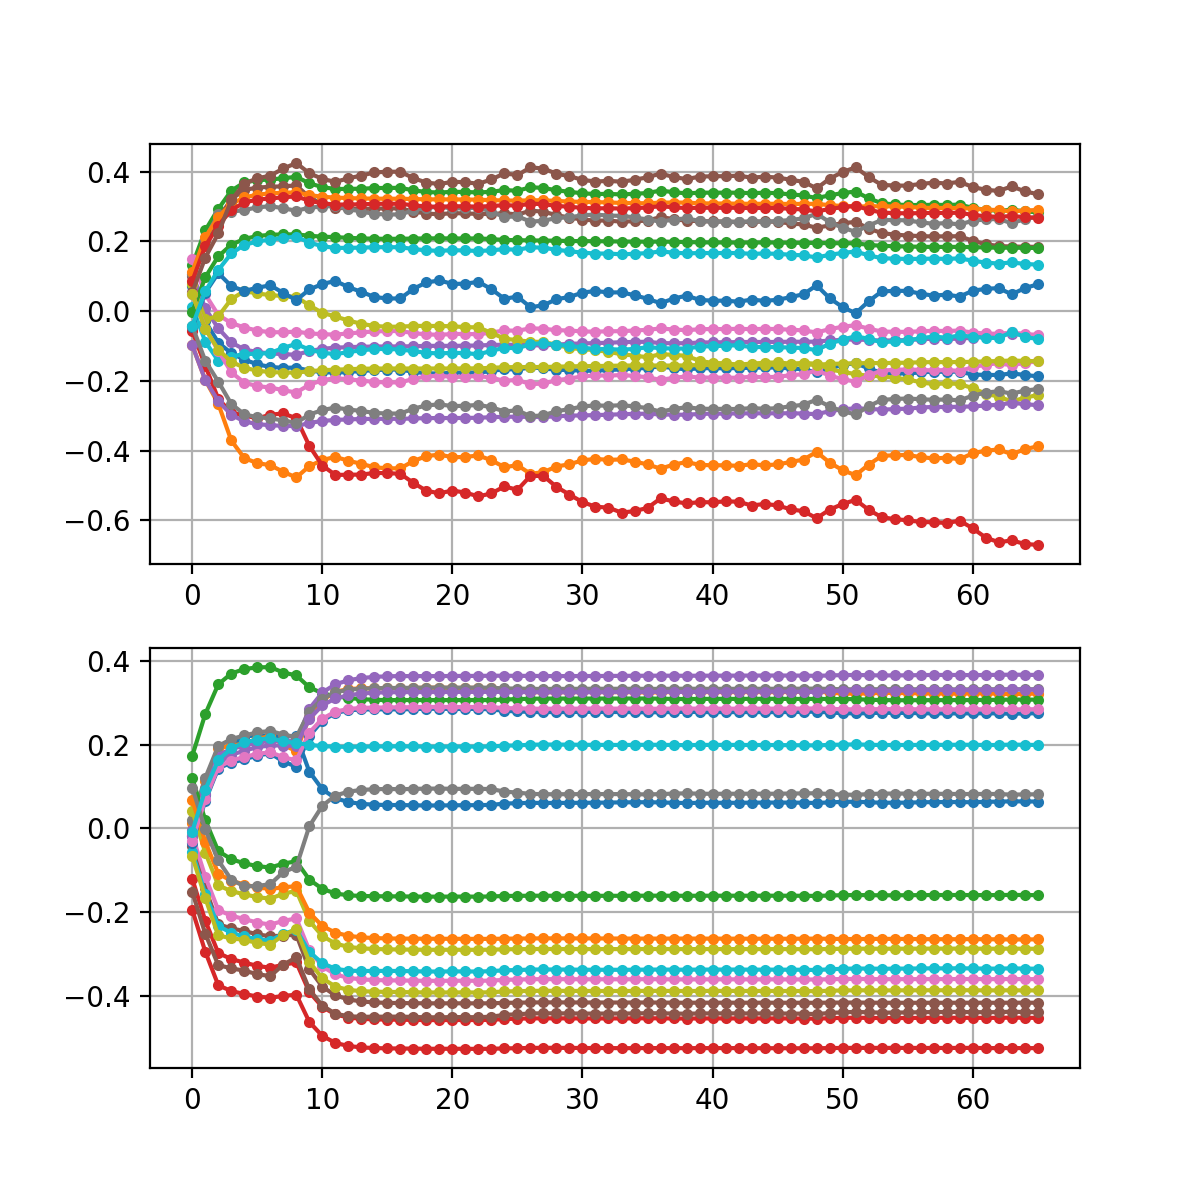

hidden_layers.0.centers
plotting neurons: [12 17]


<IPython.core.display.Javascript object>


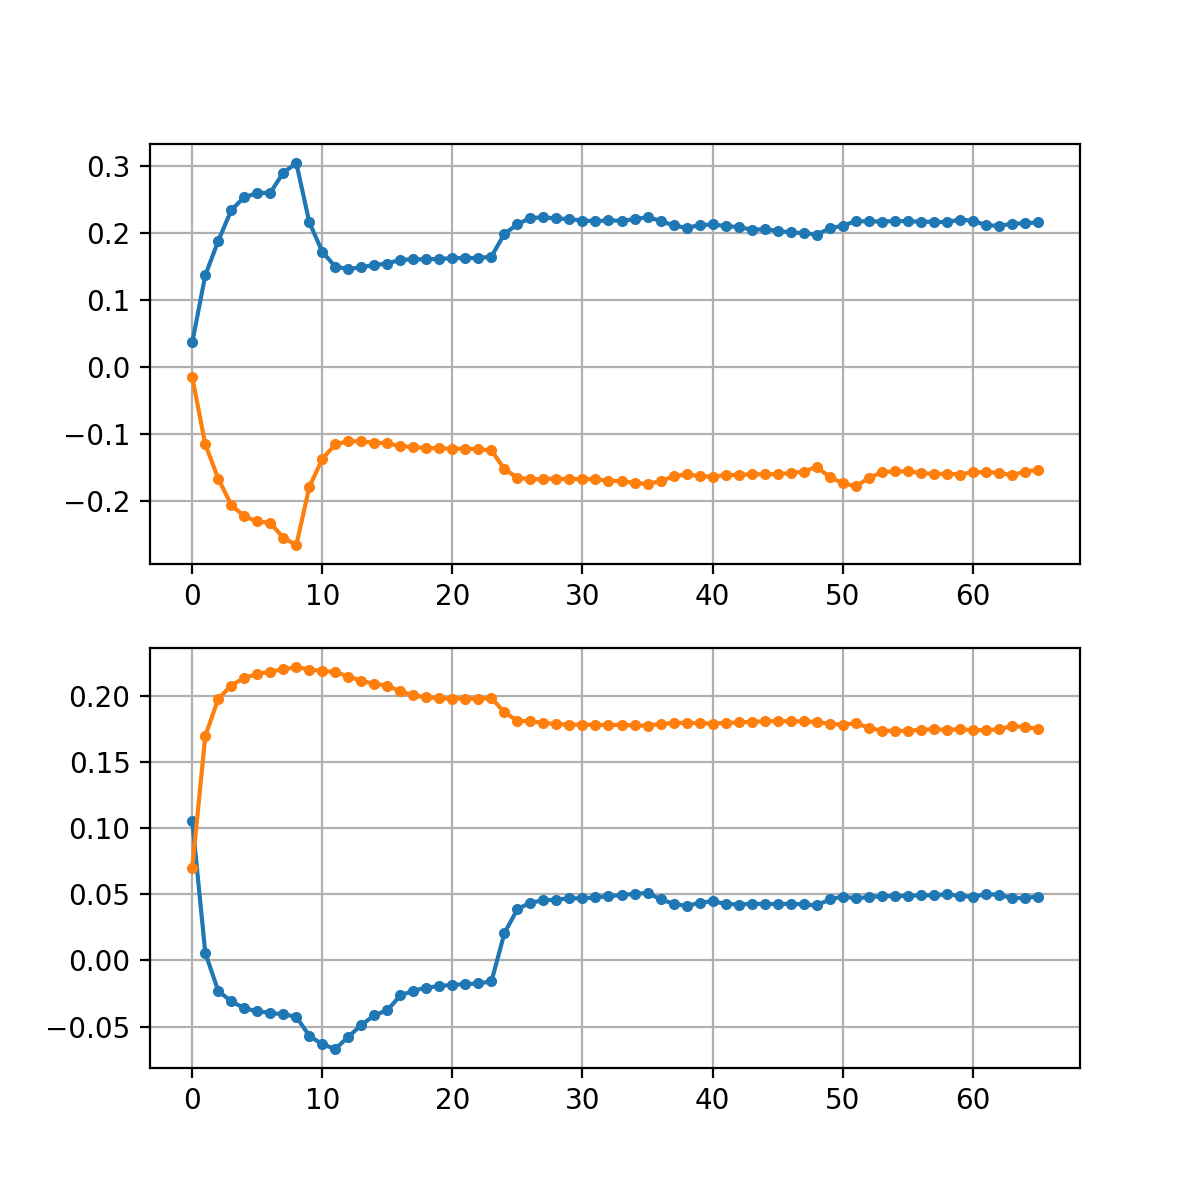

In [33]:
# plot centers history for only some hidden layer neuron
# for full FGN
for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.sigmas


<IPython.core.display.Javascript object>


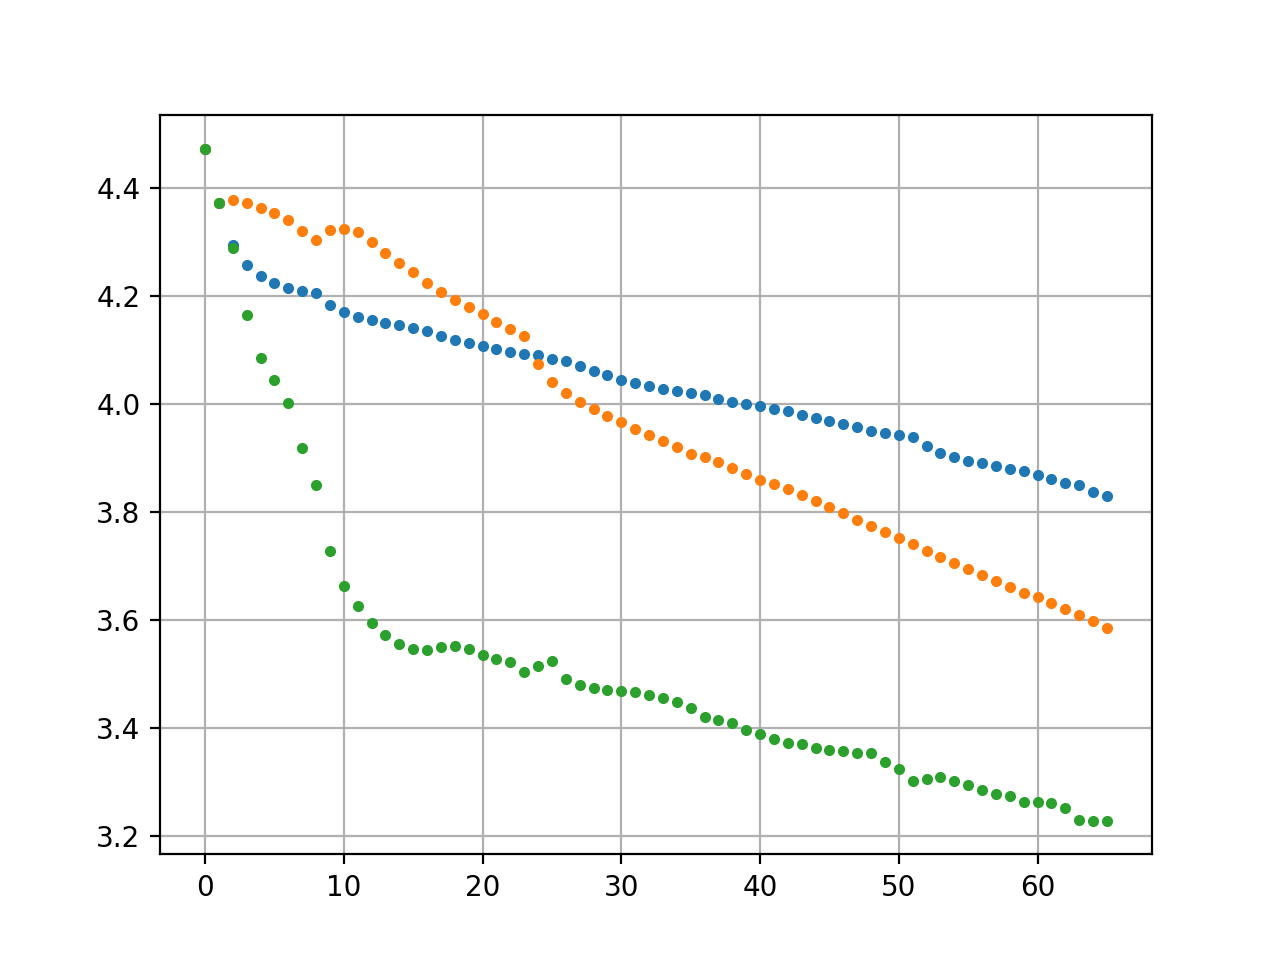

hidden_layers.2.sigmas


<IPython.core.display.Javascript object>


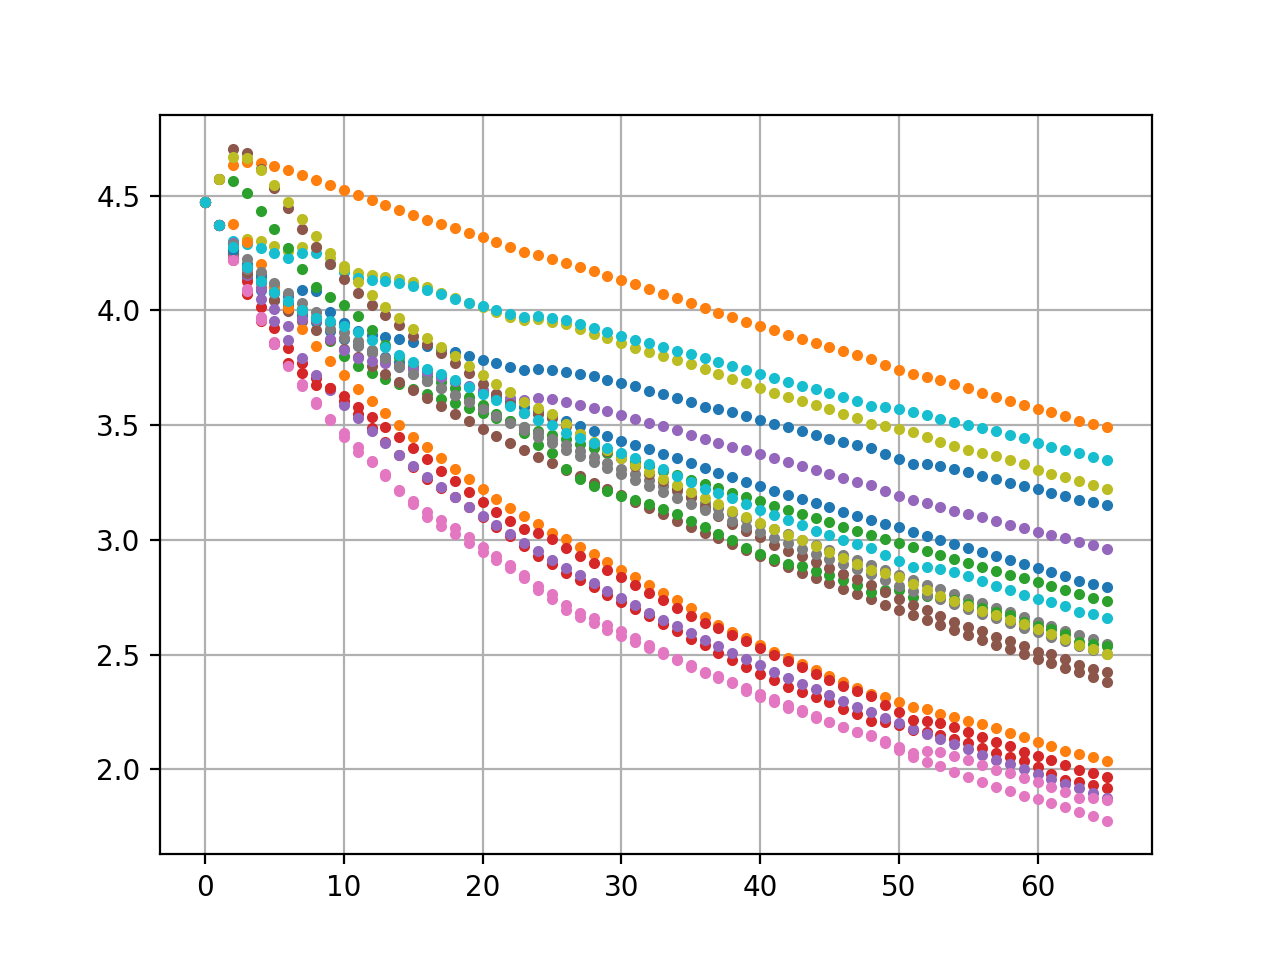

hidden_layers.0.sigmas


<IPython.core.display.Javascript object>


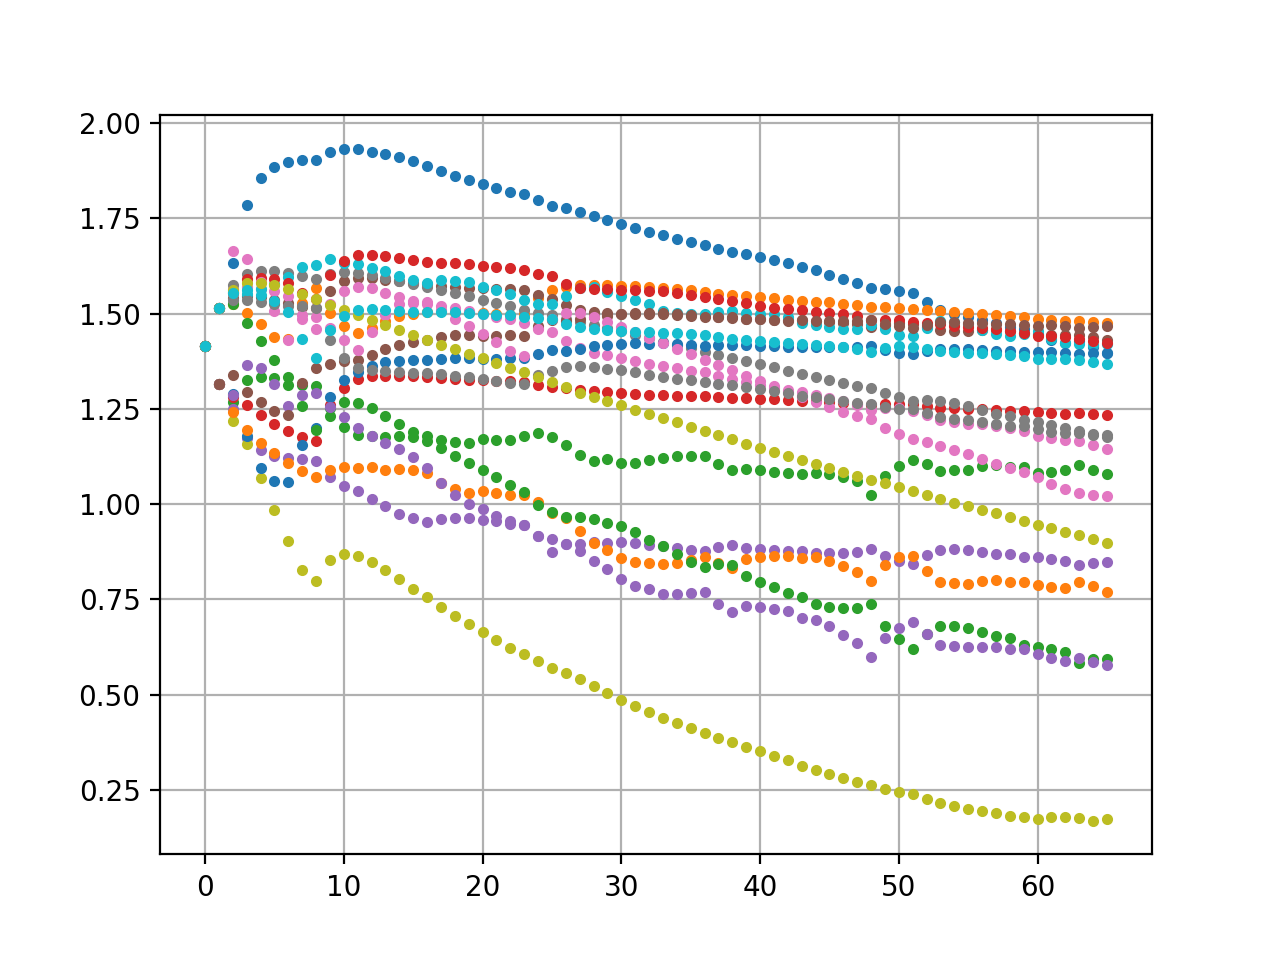

In [34]:
# check that sigma has shrunk
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(fgn_train_res['histories'][k][0])):
            plt.plot(fgn_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()